In [9]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt

# === EDITA AQUÍ ===
# Carpeta que contiene TODAS las ROIs (archivos .ome / .ome.tif / .ome.tiff)
main_dir = r"C:\Users\ADMIN\Desktop\ROIs_refinadas\Sin_NED\Exp_20250611_Sin_NED\20250612_M1_cells2"

# Extensiones a considerar
exts = (".ome.tif", ".ome.tiff", ".ome")

# Parámetros de análisis
background_value = 130      # umbral que se resta a todos los píxeles
project_over = 'T'          # 'T' (tiempo) o 'Z' (profundidad)
channel_index = 0           # canal a usar para la proyección
z_index = 0                 # plano Z para project_over='T'
t_range = None #(0, 50)           # (inicio, fin_exclusivo) en T; usa None para todo
save_projection = False     # True para guardar PNG/TIF de la proyección
print(os.listdir(main_dir))

['roi_00_ctr.ome.tif', 'roi_00_iono.ome.tif', 'roi_00_mib1.ome.tif', 'roi_01_ctr.ome.tif', 'roi_01_iono.ome.tif', 'roi_01_mib1.ome.tif', 'roi_02_ctr.ome.tif', 'roi_02_iono.ome.tif', 'roi_02_mib1.ome.tif', 'roi_03_ctr.ome.tif', 'roi_03_iono.ome.tif', 'roi_03_mib1.ome.tif']


In [10]:
def list_ome_nodes(folder, extensions):
    """
    Escanea la carpeta y construye:
      - node_names: lista de labels (uno por archivo/serie)
      - node_map: dict label -> (ruta_archivo, indice_de_serie, axes_string)
    Imprime una lista estilo Zarr con shapes normalizados a (T, C, Z, Y, X).
    """
    file_paths = [
        os.path.join(folder, f) for f in sorted(os.listdir(folder))
        if f.lower().endswith(extensions)
    ]

    node_names, node_map = [], {}
    print("Available OME nodes:")

    for path in file_paths:
        fname = os.path.basename(path)
        try:
            with tifffile.TiffFile(path) as tif:
                if not tif.series:
                    print(f"  {fname}: no data found")
                    continue

                for si, s in enumerate(tif.series):
                    axes, shape = s.axes, s.shape
                    sizes = {ax: n for ax, n in zip(axes, shape)}
                    tczyx = tuple(sizes.get(ax, 1) for ax in "TCZYX")

                    base = os.path.splitext(fname)[0]
                    label = base if len(tif.series) == 1 else f"{base}[s{si}]"

                    node_names.append(label)
                    node_map[label] = (path, si, axes)
                    print(f"  {label}: {tczyx}")   # p.ej. (T, C, Z, Y, X)

        except tifffile.TiffFileError:
            print(f"  {fname}: no es un TIFF legible (¿solo OME-XML?).")
        except Exception as e:
            print(f"  {fname}: error al leer ({type(e).__name__}: {e})")

    return node_names, node_map


def to_tczyx(arr, axes):
    """Reordena un arreglo con ejes 'axes' al orden TCZYX; crea dims faltantes con tamaño 1."""
    current_axes = list(axes)
    out = arr
    for ax in 'TCZYX':
        if ax not in current_axes:
            out = np.expand_dims(out, axis=0)
            current_axes.insert(0, ax)
    perm = [current_axes.index(ax) for ax in 'TCZYX']
    return np.transpose(out, perm)


def subtract_bg(arr, bg):
    """Resta fondo (bg) y satura negativos a 0. Devuelve float32."""
    out = arr.astype(np.float32) - float(bg)
    np.maximum(out, 0, out=out)
    return out


def mean_projection(arr_tczyx, project_over='T', channel_index=0, z_index=0, t_range=None):
    """
    Calcula proyección media 2D (Y,X):
      - project_over: 'T' o 'Z'
      - channel_index: canal a usar
      - z_index: si 'T', fija el plano Z
      - t_range: (inicio, fin_exclusivo) en T; None = todo
    """
    T, C, Z, Y, X = arr_tczyx.shape
    if not (0 <= channel_index < C):
        raise IndexError(f"channel_index fuera de rango (0..{C-1})")

    arr = arr_tczyx[:, channel_index]  # (T, Z, Y, X)

    if project_over == 'T':
        if not (0 <= z_index < Z):
            raise IndexError(f"z_index fuera de rango (0..{Z-1})")
        arr = arr[:, z_index]  # (T, Y, X)
        if t_range is not None:
            t0, t1 = max(0, t_range[0]), min(T, t_range[1])
            if t0 >= t1:
                raise ValueError("t_range inválido (inicio >= fin)")
            arr = arr[t0:t1]
        proj = arr.mean(axis=0)   # (Y, X)
        used = {'over': 'T', 'ch': channel_index, 'z': z_index,
                'T': (0, arr_tczyx.shape[0]) if t_range is None else (t0, t1)}
    elif project_over == 'Z':
        if t_range is not None:
            t0, t1 = max(0, t_range[0]), min(T, t_range[1])
            if t0 >= t1:
                raise ValueError("t_range inválido (inicio >= fin)")
            arr = arr[t0:t1]  # (Tsel, Z, Y, X)
        arr = arr.mean(axis=0)    # media sobre T -> (Z, Y, X)
        proj = arr.mean(axis=0)   # media sobre Z -> (Y, X)
        used = {'over': 'Z', 'ch': channel_index,
                'T': (0, T) if t_range is None else (t0, t1)}
    else:
        raise ValueError("project_over debe ser 'T' o 'Z'")

    return proj, used


def positive_stats(img2d):
    """Media, varianza y CV sobre píxeles > 0 de una imagen 2D."""
    v = img2d[img2d > 0]
    if v.size == 0:
        return {'mean': 0.0, 'variance': 0.0, 'cv': np.nan, 'n': 0}
    return {
        'mean': float(np.round(v.mean(), 3)),
        'variance': float(np.round(v.var(), 3)),
        'cv': float(np.round(v.std() / v.mean(), 3)),
        'n': int(v.size)
    }

In [11]:
node_names, node_map = list_ome_nodes(main_dir, exts)

if not node_names:
    raise RuntimeError("No se encontraron archivos OME-TIFF válidos en la carpeta indicada.")

print(list_ome_nodes)

Available OME nodes:
  roi_00_ctr.ome: (48001, 1, 1, 64, 64)
  roi_00_iono.ome: (48001, 1, 1, 64, 64)
  roi_00_mib1.ome: (48001, 1, 1, 64, 64)
  roi_01_ctr.ome: (48001, 1, 1, 64, 64)
  roi_01_iono.ome: (48001, 1, 1, 64, 64)
  roi_01_mib1.ome: (48001, 1, 1, 64, 64)
  roi_02_ctr.ome: (48001, 1, 1, 64, 64)
  roi_02_iono.ome: (48001, 1, 1, 64, 64)
  roi_02_mib1.ome: (48001, 1, 1, 64, 64)
  roi_03_ctr.ome: (48001, 1, 1, 64, 64)
  roi_03_iono.ome: (48001, 1, 1, 64, 64)
  roi_03_mib1.ome: (48001, 1, 1, 64, 64)
<function list_ome_nodes at 0x0000012332E831A0>



Loading node: roi_00_ctr.ome


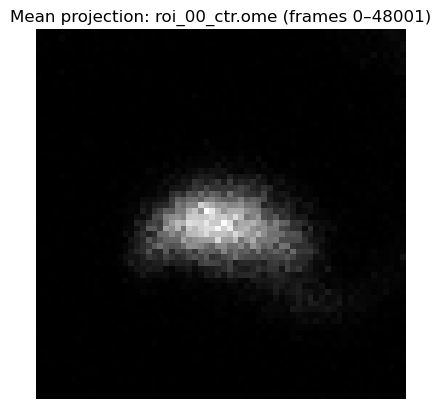

In [12]:
# Elige por índice como antes (p.ej., node_names[10]) o por nombre exacto.
node_to_use = node_names[0]
print(f"\nLoading node: {node_to_use}")

path, series_idx, axes = node_map[node_to_use]
with tifffile.TiffFile(path) as tif:
    s = tif.series[series_idx]
    data = s.asarray()                 # arreglo con ejes 'axes'
    arr_tczyx = to_tczyx(data, s.axes) # (T, C, Z, Y, X)

# Sustracción de fondo
arr_bg = subtract_bg(arr_tczyx, background_value)

# Proyección media
proj2d, used = mean_projection(
    arr_bg,
    project_over=project_over,
    channel_index=channel_index,
    z_index=z_index,
    t_range=t_range
)

# Mostrar
t_info = "" if 'T' not in used else f" (frames {used['T'][0]}–{used['T'][1]})"
plt.imshow(proj2d, cmap='gray')
plt.title(f"Mean projection: {node_to_use}{t_info}")
plt.axis('off')
plt.show()

# Guardado opcional
if save_projection:
    base = os.path.splitext(os.path.basename(path))[0]
    out_png = os.path.join(main_dir, f"{base}_meanproj.png")
    out_tif = os.path.join(main_dir, f"{base}_meanproj.tif")
    plt.imsave(out_png, proj2d, cmap='gray')
    tifffile.imwrite(out_tif, proj2d.astype(np.float32), photometric='minisblack')
    print(f"Guardados:\n  {out_png}\n  {out_tif}")

In [18]:
stats_per_node = {}

for label in node_names:
    path, series_idx, axes = node_map[label]
    try:
        with tifffile.TiffFile(path) as tif:
            s = tif.series[series_idx]
            data = s.asarray()
            arr_tczyx = to_tczyx(data, s.axes)          # (T, C, Z, Y, X)
            corrected = subtract_bg(arr_tczyx, background_value)

            # Píxeles válidos (>0) en TODO el stack (T,C,Z,Y,X)
            valid_pixels = corrected[corrected > 0]

            if valid_pixels.size > 0:
                mean_val = float(np.round(valid_pixels.mean(), 1))
                #var_val  = float(np.round(valid_pixels.var(), 1))
                #cv_val   = float(np.round(valid_pixels.std() / valid_pixels.mean(), 2))
                stats_per_node[label] = {'mean': mean_val, 'variance': var_val, 'cv': cv_val}
            else:
                stats_per_node[label] = None
    except Exception as e:
        print(f"{label}: error ({type(e).__name__}: {e})")
        stats_per_node[label] = None

# Salida estilo tu script original
for label, stats in stats_per_node.items():
    if stats is not None:
        print(f"{label}: Mean = {stats['mean']:.1f}, Variance = {stats['variance']:.1f}, CV = {stats['cv']:.2f}")
    else:
        print(f"{label}: no data")

roi_00_ctr.ome: Mean = 10.1, Variance = 14.7, CV = 1.23
roi_00_iono.ome: Mean = 4.9, Variance = 14.7, CV = 1.23
roi_00_mib1.ome: Mean = 6.0, Variance = 14.7, CV = 1.23
roi_01_ctr.ome: Mean = 9.6, Variance = 14.7, CV = 1.23
roi_01_iono.ome: Mean = 4.6, Variance = 14.7, CV = 1.23
roi_01_mib1.ome: Mean = 6.5, Variance = 14.7, CV = 1.23
roi_02_ctr.ome: Mean = 3.2, Variance = 14.7, CV = 1.23
roi_02_iono.ome: Mean = 3.2, Variance = 14.7, CV = 1.23
roi_02_mib1.ome: Mean = 3.2, Variance = 14.7, CV = 1.23
roi_03_ctr.ome: Mean = 3.2, Variance = 14.7, CV = 1.23
roi_03_iono.ome: Mean = 3.2, Variance = 14.7, CV = 1.23
roi_03_mib1.ome: Mean = 3.1, Variance = 14.7, CV = 1.23
